
--- Using TensorFlow Version: 2.20.0 ---

--- Section 1: Initializing Setup ---
Class names inferred from existing split: ['Anthracnose', 'BacterialSpot', 'Curl', 'Healthy', 'RingSpot']

--- Section 2: Creating Data Pipelines ---
Found 1509 files belonging to 5 classes.
Found 324 files belonging to 5 classes.
Found 326 files belonging to 5 classes.
Data pipelines created successfully from existing split.

--- Section 4: Building Swin Transformer Model ---



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Swin Transformer model built and compiled.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_backbone_layer             │ (None, 49, 768)        │             0 │
│ (SwinBackboneLayer)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 768)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         3,845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,845 (15.02 KB)

 Trainable params: 3,845 (15.02 KB)

 Non-trainable params: 0 (0.00 B)


--- Section 5: Starting Model Training ---
Epoch 1/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.2220 - loss: 1.7200 - val_accuracy: 0.2685 - val_loss: 1.5715
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.2611 - loss: 1.6547 - val_accuracy: 0.3642 - val_loss: 1.5222
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.3015 - loss: 1.5877 - val_accuracy: 0.3889 - val_loss: 1.4836
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.3088 - loss: 1.5569 - val_accuracy: 0.4074 - val_loss: 1.4489
Epoch 5/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.3400 - loss: 1.5274 - val_accuracy: 0.4105 - val_loss: 1.4172
Epoch 6/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.3671 - loss: 1.4789 - val_accuracy: 0.4352 - val_loss: 1.3876
Epoch 7/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.3784 - loss: 1.4488 - val_accuracy: 0.4383 - val_loss: 1.3606
Epoch 8/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.42

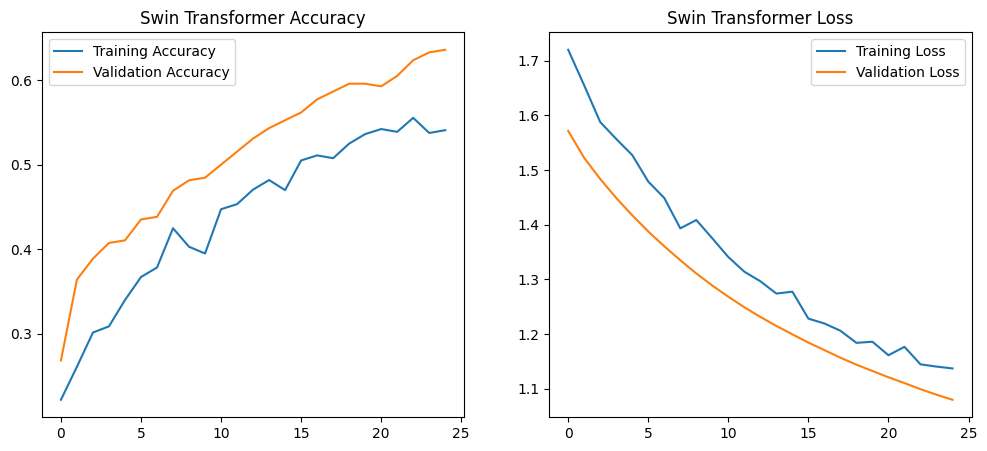

11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step

--- Swin Transformer Classification Report ---
                precision    recall  f1-score   support

  Anthracnose       0.67      0.41      0.51        54
BacterialSpot       0.53      0.51      0.52        69
         Curl       0.58      0.72      0.64        88
      Healthy       0.79      0.63      0.70        35
     RingSpot       0.67      0.76      0.71        80

     accuracy                           0.62       326
    macro avg       0.65      0.60      0.62       326
 weighted avg       0.63      0.62      0.62       326


--- Confusion Matrix ---


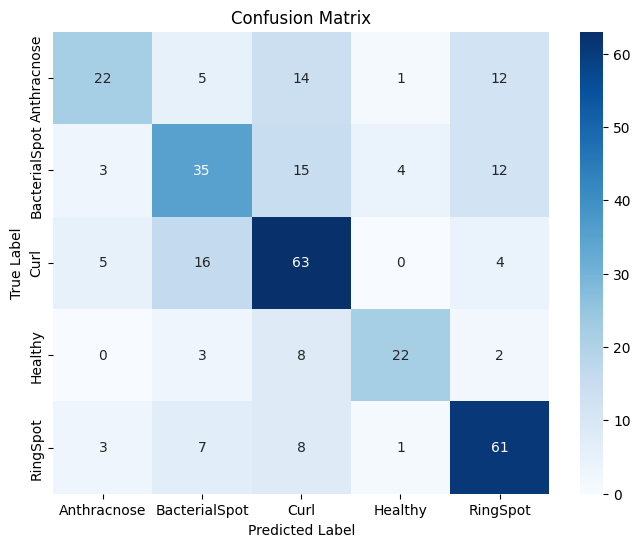


--- Script Finished ---


In [2]:
# ==============================================================================
# STANDALONE SCRIPT FOR PAPAYA LEAF DISEASE CLASSIFICATION (Swin Transformer)
#
# This script uses the `transformers` library for the Swin Transformer backbone
# and integrates it with TensorFlow/Keras for training and evaluation.
# ==============================================================================

import os
import shutil
import random
import pathlib
import numpy as np
import tensorflow as tf
import keras_hub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from transformers import SwinModel
import torch

print(f"\n--- Using TensorFlow Version: {tf.__version__} ---")

# --- 1. SETUP AND CONSTANTS ---
print("\n--- Section 1: Initializing Setup ---")
SEED = 42
tf.keras.utils.set_random_seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# We will use the same data split as the successful ViT run
SPLIT_BASE_DIR = pathlib.Path('papaya_data_split_vit')
train_dir = SPLIT_BASE_DIR / "train"
val_dir = SPLIT_BASE_DIR / "validation"
test_dir = SPLIT_BASE_DIR / "test"

CLASS_NAMES = sorted([item.name for item in train_dir.glob("*") if item.is_dir()])
NUM_CLASSES = len(CLASS_NAMES)

print("Class names inferred from existing split:", CLASS_NAMES)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.0001

# --- 2. DATA PIPELINES (using existing split) ---
print("\n--- Section 2: Creating Data Pipelines ---")
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical', shuffle=True, seed=SEED
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical', shuffle=False
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='categorical', shuffle=False
)

# Preprocessing for Swin Transformer (normalize to [0, 1] and match expected input format)
def preprocess_for_swin(image, label):
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

train_ds = train_ds.map(preprocess_for_swin, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_for_swin, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_for_swin, num_parallel_calls=tf.data.AUTOTUNE)

AUTOTUNE = tf.data.AUTOTUNE
train_ds, val_ds, test_ds = (ds.cache().prefetch(buffer_size=AUTOTUNE) for ds in [train_ds, val_ds, test_ds])
print("Data pipelines created successfully from existing split.")

# --- 3. HELPER FUNCTIONS ---
def plot_history(history, model_name):
    acc, val_acc, loss, val_loss = history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss']
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title(f'{model_name} Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title(f'{model_name} Loss')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# --- 4. MODEL BUILDING (Swin Transformer) ---
print("\n--- Section 4: Building Swin Transformer Model ---")
tf.keras.backend.clear_session()

# Define a custom Keras layer for the PyTorch Swin backbone
class SwinBackboneLayer(tf.keras.layers.Layer):
    def __init__(self, model_name="microsoft/swin-tiny-patch4-window7-224"):
        super(SwinBackboneLayer, self).__init__()
        self.swin = SwinModel.from_pretrained(model_name)
        self.swin.eval()  # Set to evaluation mode (no training)
        for param in self.swin.parameters():
            param.requires_grad = False  # Freeze the backbone

    def call(self, inputs):
        def swin_forward(inp):
            input_np = inp.numpy()
            inputs_torch = torch.from_numpy(input_np).permute(0, 3, 1, 2)  # [batch, H, W, C] -> [batch, C, H, W]
            with torch.no_grad():
                outputs = self.swin(inputs_torch).last_hidden_state
            output_np = outputs.detach().numpy()
            return output_np

        output = tf.py_function(func=swin_forward, inp=[inputs], Tout=tf.float32)
        output.set_shape([None, 49, 768])  # Symbolic shape: (batch, sequence_length=49, hidden_size=768)
        return output

# Build the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = SwinBackboneLayer()(inputs)
x = tf.keras.layers.GlobalAveragePooling1D()(x)  # Pool over the sequence dimension
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model_swin = tf.keras.Model(inputs, outputs)

# Compile with jit_compile=False to disable XLA and avoid py_function incompatibility
model_swin.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    jit_compile=False
)

print("Swin Transformer model built and compiled.")
model_swin.summary()

# Disable additional JIT optimizations if needed (for redundancy)
tf.config.optimizer.set_jit(False)

# --- 5. MODEL TRAINING & SAVING ---
print("\n--- Section 5: Starting Model Training ---")
history_swin = model_swin.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)
print("\n--- Saving Swin Transformer model ---")
model_swin.save("papaya_disease_swin_transformer.keras")
print("Model saved to papaya_disease_swin_transformer.keras")

# --- 6. MODEL EVALUATION ---
print("\n--- Section 6: Evaluating Model Performance ---")
plot_history(history_swin, "Swin Transformer")
y_pred_probs = model_swin.predict(test_ds)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(np.concatenate([y for x, y in test_ds]), axis=1)
print("\n--- Swin Transformer Classification Report ---\n", classification_report(y_true_labels, y_pred_labels, target_names=CLASS_NAMES))
print("\n--- Confusion Matrix ---")
plot_confusion_matrix(y_true_labels, y_pred_labels, CLASS_NAMES)
print("\n--- Script Finished ---")